#Transfer tif to png (done in local, need to be updated in jupyter notebook)
import cv2
import os
import numpy as np

path = os.getcwd()
print(path)

imagesDirectory= os.path.join(path,"sr_data")  # tif image directory
distDirectory = os.path.dirname(imagesDirectory)
distDirectory = os.path.join(distDirectory, "sr_png")# save directory

for imageName in os.listdir(imagesDirectory):
    imagePath = os.path.join(imagesDirectory, imageName)
    image = cv2.imread(imagePath)# open tif image
    img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    distImagePath = os.path.join(distDirectory, imageName[:-4]+'.png')# save imgaes
    cv2.imwrite(distImagePath,img)# write imgaes

In [19]:
#Traninig

In [11]:
import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


epoch=0
n_epochs=200
#dataset_name="img_hr"
batch_size=4
lr=0.0002
b1=0.5
b2=0.999
decay_epoch=200
n_cpu=8
hr_height=512
hr_width=512
channels=1
sample_interval=50
checkpoint_interval=50

cuda = torch.cuda.is_available()

hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet(in_channels=channels, out_channels=channels)
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    #ImageDataset("../../data/%s" % opt.dataset_name, hr_shape=hr_shape),
    ImageDataset("../../data/", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

# ----------
#  Training
# ----------

Dloss=[]
Gloss=[]

for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
    ##    print(imgs_hr)

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        #print(gen_hr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
    #    gen_features = feature_extractor(gen_hr)
        gen_features = feature_extractor(torch.cat((gen_hr,gen_hr,gen_hr),1))
        
    #    real_features = feature_extractor(imgs_hr)
        real_features = feature_extractor(torch.cat((imgs_hr,imgs_hr,imgs_hr),1))
        
    #    loss_content = criterion_content(gen_features, real_features.detach())
        loss_content = criterion_content(gen_hr, imgs_hr.detach()) + criterion_content(gen_features, real_features.detach())
    #    loss_content = criterion_content(gen_hr, imgs_hr.detach())

        # Total loss
        loss_G = loss_content + 1e-5 * loss_GAN  
##        loss_G = loss_content    #No GAN loss

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
            % (epoch+1, n_epochs, i+1, len(dataloader), loss_D.item(), loss_G.item())
        )

        Dloss.append(loss_D.item())
        Gloss.append(loss_G.item())

        batches_done = epoch * len(dataloader) + i
        if (batches_done+1) % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(imgs_hr, nrow=1,normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr, imgs_hr), -1)
            
            save_image(imgs_hr, "images/tif_epoch200_data200_GAN0.1_ep4/hr%d.png" % batches_done, normalize=False) #save the ground truth of hr
            save_image(gen_hr, "images/tif_epoch200_data200_GAN0.1_ep4/gen%d.png" % batches_done, normalize=False) #save predicted results of hr
            save_image(img_grid, "images/tif_epoch200_data200_GAN0.1_ep4/%d.png" % batches_done, normalize=False) #save whole table: lr, gen_hr and hr

             #print("batch_done:%d\n" %batches_done)
  
    if checkpoint_interval != -1 and (epoch+1) % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)


[Epoch 1/200] [Batch 1/25] [D loss: 0.570825] [G loss: 0.593409]
[Epoch 1/200] [Batch 2/25] [D loss: 4.532930] [G loss: 0.404221]
[Epoch 1/200] [Batch 3/25] [D loss: 1.421505] [G loss: 0.316859]
[Epoch 1/200] [Batch 4/25] [D loss: 0.943829] [G loss: 0.297145]
[Epoch 1/200] [Batch 5/25] [D loss: 0.422280] [G loss: 0.225531]
[Epoch 1/200] [Batch 6/25] [D loss: 0.484123] [G loss: 0.192028]
[Epoch 1/200] [Batch 7/25] [D loss: 0.281911] [G loss: 0.193787]
[Epoch 1/200] [Batch 8/25] [D loss: 0.215377] [G loss: 0.204201]
[Epoch 1/200] [Batch 9/25] [D loss: 0.215721] [G loss: 0.203752]
[Epoch 1/200] [Batch 10/25] [D loss: 0.174550] [G loss: 0.231430]
[Epoch 1/200] [Batch 11/25] [D loss: 0.184915] [G loss: 0.264256]
[Epoch 1/200] [Batch 12/25] [D loss: 0.195023] [G loss: 0.215443]
[Epoch 1/200] [Batch 13/25] [D loss: 0.258364] [G loss: 0.217763]
[Epoch 1/200] [Batch 14/25] [D loss: 0.237990] [G loss: 0.285006]
[Epoch 1/200] [Batch 15/25] [D loss: 0.149770] [G loss: 0.140373]
[Epoch 1/200] [Batc

KeyboardInterrupt: 

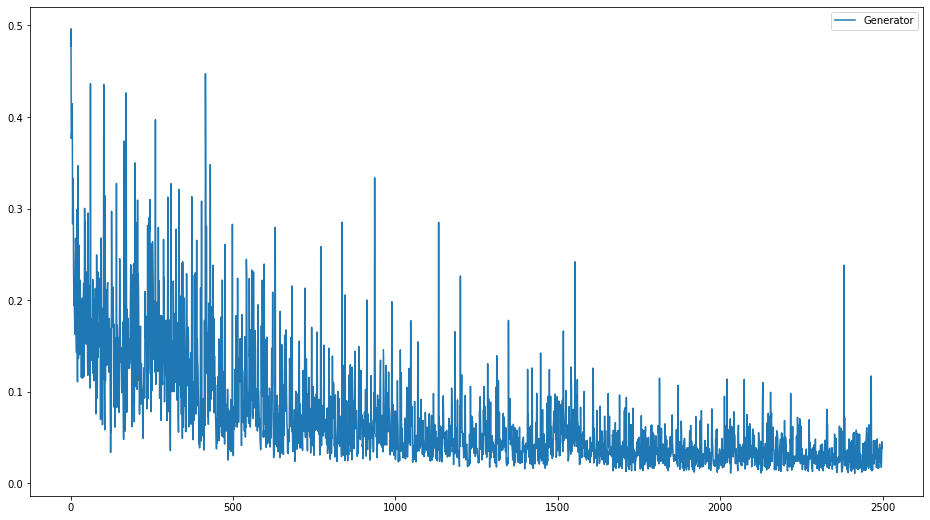

In [ ]:
from matplotlib import pyplot
#np.save('Loss/Dloss8.npy',Dloss)
np.save('Loss/4_Jan10.npy',Gloss)
#pyplot.plot(Dloss, label='Discriminator')

pyplot.figure(figsize=(16,9))
pyplot.plot(Gloss, label='Generator')
pyplot.legend()
pyplot.savefig('3_Jan10.png') 
pyplot.show()


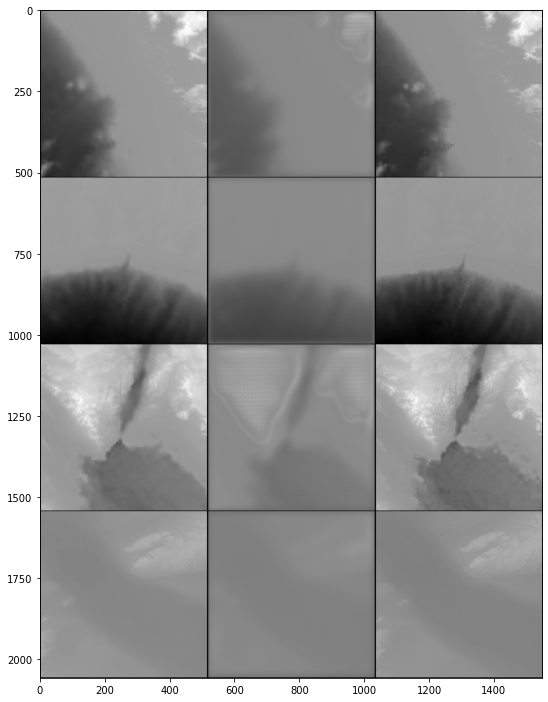

In [3]:
#print the images for the last batch
#three columns: imgs_lr, gen_hr, imgs_hr

import matplotlib.pyplot as plt
fig, axes=plt.subplots(1,1,figsize=(9,15))
axes.imshow(img_grid.cpu().numpy()[0], cmap='gray') 

In [23]:
import cv2
from math import log10, sqrt
# Test loss   

def PSNR(original, generator):
    mse = np.mean((original - generator) ** 2)
    if(mse == 0): # MSE is zero means no noise is present in the signal .
                # Therefore PSNR have no importance.
        return 100
    max_pixel = 255
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
    
img_hr = 'images/hr'+str(batches_done)+'.png'
img_gen = 'images/gen'+str(batches_done)+'.png'
original = cv2.imread(img_hr)
generator = cv2.imread(img_gen)
value = PSNR(original, generator) 
value

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

img_hr = 'images/hr'+str(batches_done)+'.png'
img_gen = 'images/gen'+str(batches_done)+'.png'

imgs_hr = cv2.imread(img_hr,0)
img = imgs_hr
rows, cols = img.shape

gen_hr = cv2.imread(img_gen,0)
img_noise = gen_hr

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range = img_noise.max() - img_noise.min())

print('SSIM of the original image: %d, SSIM of the generated image: %f'%(ssim_none,ssim_noise))
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
#                          sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
# ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
# ax[0].set_title('Original image')

# ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
# ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
# ax[1].set_title('Image with noise')

# plt.tight_layout()
# plt.show()

SSIM of the original image: 1, SSIM of the generated image: 0.880238
